<a href="https://colab.research.google.com/github/rafaelgrecco/DS-ML-Projects/blob/master/Previs%C3%A3o_de_Demanda_com_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#*Séries Temporais com Prophet*
O objetvo final desse Notebook é manusear séries temporais e posteriormente aplicar a ferramenta **Prophet** para prever a saída do nosso banco de dados. Para ambientar-se melhor o pŕoximo tópico conta com informações tanto sobre séries temporais, como a ferramente utilizada para o **forecasting**.
##*Conhecendo o Prophet*
Realizar previsões confiáveis e fiés a realidade é um verdadeiro desafio para engenheiros de machine learning, uma vez que os modelos estatísticos que podem ser aplicados, são de extrema complexidade. 

Pensando nisso o **Prophet** foi desenvolvido para realizar forecasting em séries temporais e posteriormente disponibilazdo como projeto **Open Source** pelo Facebook, a documentação oficial pode ser encontrar [Neste Link](https://facebook.github.io/prophet/).
##*Como o Prophet realiza as previsões*
O *prophet* realiza previsões em séries temporais com base em um **modelo aditivo** em que há tendências não lineares e essas são asjustadas com sazonalidade diárias, semanal, mensal ou anual.

Como já mencionado o Prophet foi desenvolvido pelo Facebook, devido a isso, ele é muito poderoso, para lidar com problemas caracterizados da seguinte forma:

* Dados coletados por longos períodos, podendo ser meses ou até mesmo anos;
* Fortes sazonalidades;
* Feriados ou data especiais;
* Tendência de crescimento não linear.
O modelo ao qual o prophet foi modelado, possui três características principais: Tendência, sazonalidade, feriados, isso pode ser expresso através da seguinte equação:

$$y(t)=g(t)+s(t)+h(t)+\epsilon_{t}$$
Onde:

* $g(t)$ é a tendência, ou seja, ela é responsável por modelar mudanças não periódicas;
* $s(t)$ caracteriza as mudanças periódicas;
* $h(t)$ representa os efeitos dos feriados;
* $\epsilon_{t}$ representa o erro, ou seja, mudanças que não foram reconhecidas pelo modelo.
Os parâmetros para a equação estão setados de forma padrão, no entanto, caso a forma padrão, tenha resultados abaixo do esperado, consultando a documentação, é possível modificar esses valores para que eles de adequem melhor ao problema.

###*Tendência $g(t)$*
A forma padrão para a tendência é 
$$g(t)=\frac{C}{1+e^{-k(t-m)}}$$

Onde:
* $C$ é a capacidade, ou seja, o ponto de saturação, devido a isso $C=C(t)$. Vale destacar que 
$$\lim_{t \rightarrow \infty}g(t)=C$$
* $k$ é a taxa de crescimento que não é constante;
* $m$ é o parâmetro de deslocamento

###*Sazonalidade*
Os componentes que definem a **Sazonalidade** são apróximados pelos modos de Fourier:
$$
s(t)=\sum_{n=1}^{N}=(a_{n}cos(\frac{2\pi nt}{P})+b_{n}sin(\frac{2\pi nt}{P}))$$
Onde $P$ é o período.



#*O problema abordado neste exemplo*
O centro de abrigo de animais de Austin, Texas, abriga mais de 16 mil animais anualmente, além de oferecer suporte veterinário e outros serviços.

O principal Objetivo é encontrar um novo lar para esses animais, infelizmente alguns animais chegam ao abrigo muito debilitados e alguns desses são sacrificados. A meta do Austin animal center é conseguir que 90% ou mais desses animais consigam um desfecho positivo.

Pensando nesse objetivo da própria organização, no exemplo, será realizado um forecasting da saída desses animais para um lar adequado.

#*Justificativa*
Fazer a previsão do número de animais que encontraram um lar, é de extrema importância, uma vez que, isso possibilita, planejar a compra de insumos, contratação de funcionários e colaboradores, prever períodos em que o número de adoções vão diminuir e nesses períodos fazer campanhas para a adoção de animais.

#*Aquisição dos dados*

Os dados utilizados, foram disponibilizados pelo [Austin Animal Center](http://www.austintexas.gov/content/austin-animal-center) e podem ser baixados no [City of Austin Open Data Portal](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238)

##*Detalhes sobre o dataset*
o *dataset* utilizado neste projeto contém **117 mil linhas** e **12 colunas**

#*Bibliotecas necessárias*
Iniciamente as bibliotecas que serão usadas no decorrer do código, serão importadas e também nessa etapa será setada uma configuração para melhorar a visualização de gráficos e imagens.

In [ ]:
# bibliotecas necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from fbprophet import Prophet 
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

import warnings
warnings.filterwarnings('ignore')

# melhorar a visualização
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.style.use( 'ggplot' )
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)

#*Análise exploratória*

##*Visualizando as 5 primeiras entradas no dataframe*

Nesta etapa, vamos ver as 5 primeiras entradas do dataframe, com a finalidade de conhecer mais sobre os dados que estão sendo trabalhados.
Observando a saída que foi obtida, pode-se notar que os dados estão muito bem detalhados, contendo as seguintes colunas:

* Animal ID
* Name
* DateTime
* MonthYear
* Date of Birth
* Outcome Type
* Outcome Subtype
* Animal Type
* Sex upon Outcome
* Age upon Outcome
* Breed
* Color

Uma atenção especial será dada as colunas `DateTime` e `Outcome Type`, a primeira é a coluna onde esta contida a data em que cada animal chegou e a segunda, contém o desfecho desse animal, podendo ser:

* Adoption
* Transfer
* Return to Owner
* Euthanasia
* Died
* Rto-Adopt
* Disposal
* Missing
* Relocate

In [ ]:
path = 'https://raw.githubusercontent.com/rafaelgrecco/Data-Science/main/datasets/shelter_animal_outcomes.csv'
df = pd.read_csv(path)
df.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A794011,Chunk,05/08/2019 06:20:00 PM,05/08/2019 06:20:00 PM,05/02/2017,Rto-Adopt,NaN,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Gizmo,07/18/2018 04:02:00 PM,07/18/2018 04:02:00 PM,07/12/2017,Adoption,NaN,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,A720371,Moose,02/13/2016 05:59:00 PM,02/13/2016 05:59:00 PM,10/08/2015,Adoption,NaN,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
3,A674754,NaN,03/18/2014 11:47:00 AM,03/18/2014 11:47:00 AM,03/12/2014,Transfer,Partner,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby
4,A689724,*Donatello,10/18/2014 06:52:00 PM,10/18/2014 06:52:00 PM,08/01/2014,Adoption,NaN,Cat,Neutered Male,2 months,Domestic Shorthair Mix,Black


##*Convertendo a coluna `DateTime` em datetime*

In [ ]:
# colocando no formato datetime
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117416 entries, 0 to 117415
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Animal ID         117416 non-null  object        
 1   Name              80599 non-null   object        
 2   DateTime          117416 non-null  datetime64[ns]
 3   MonthYear         117416 non-null  object        
 4   Date of Birth     117416 non-null  object        
 5   Outcome Type      117408 non-null  object        
 6   Outcome Subtype   53247 non-null   object        
 7   Animal Type       117416 non-null  object        
 8   Sex upon Outcome  117413 non-null  object        
 9   Age upon Outcome  117369 non-null  object        
 10  Breed             117416 non-null  object        
 11  Color             117416 non-null  object        
dtypes: datetime64[ns](1), object(11)
memory usage: 10.7+ MB


Como é possível observar, a coluna datetime está no formato datetime.

##*Identificando valores nulos*
Com essa saída, pode-se notar que o a coluna `Name`, `Outcome Type`, `Outcome Subtype`, `Sex upon Outcome` e `Age upon Outcome` contém dados faltantes, com toda certeza a coluna name teria dados não preenchidos, uma vez que muitos animais que o abrigo recolhe, são de rua e não possuem nome, o mesmo vale para a coluna age. Outcome subtype, por sua vez é complemento da Outcome type, logo, muitas vezes fica em branco mesmo

In [ ]:
df.isnull().sum()

Animal ID               0
Name                36817
DateTime                0
MonthYear               0
Date of Birth           0
Outcome Type            8
Outcome Subtype     64169
Animal Type             0
Sex upon Outcome        3
Age upon Outcome       47
Breed                   0
Color                   0
dtype: int64

##*Visualizando algumas informações sobre os dados*

In [ ]:
df.describe()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
count,117416,80599,117416,117416,117416,117408,53247,117416,117413,117369,117416,117416
unique,104978,18867,96710,96710,6806,9,22,5,5,50,2568,585
top,A721033,Max,2016-04-18 00:00:00,04/18/2016 12:00:00 AM,04/21/2014,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,33,525,39,39,117,51722,29119,66777,41234,21150,30746,12337
first,NaN,NaN,2013-10-01 09:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2020-04-30 18:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##*Visualizando qual `Outcome Type` é mais comum*
é possível ver que a maioria dos animais são adotados, ou transferidos e retornam para seus donos,esses formam o top 3 das saídas dos animais, infelizmente os próximos 2 em maior número são a Eutanasia e morte. 

No entanto, é possível verificar que o objetivo do abrigo está sendo alcançado, que é minimizar as mortes e as eutanasias.  

In [ ]:
df['Outcome Type'].value_counts()

Adoption           51722
Transfer           34892
Return to Owner    20636
Euthanasia          7890
Died                1075
Rto-Adopt            611
Disposal             495
Missing               67
Relocate              20
Name: Outcome Type, dtype: int64

#*Preparando os dados para o forecast*

Queremos que ao final do Notebook, seja possível prever o número de animais que serão adotados ou que retornarão aos seus donos, portanto, a primeiras coisa que vamos fazer é isolar esses casos em um único dataframe que vamos chamar de `df_adocao`.

In [ ]:
df_adocao = df[(df['Outcome Type'] =='Adoption') | (df['Outcome Type'] == 'Return to Owner')]

# visualizando as primeiras entradas do dataframe recém criado
df_adocao.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
1,A776359,Gizmo,2018-07-18 16:02:00,07/18/2018 04:02:00 PM,07/12/2017,Adoption,NaN,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,A720371,Moose,2016-02-13 17:59:00,02/13/2016 05:59:00 PM,10/08/2015,Adoption,NaN,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
4,A689724,*Donatello,2014-10-18 18:52:00,10/18/2014 06:52:00 PM,08/01/2014,Adoption,NaN,Cat,Neutered Male,2 months,Domestic Shorthair Mix,Black
5,A680969,*Zeus,2014-08-05 16:59:00,08/05/2014 04:59:00 PM,06/03/2014,Adoption,NaN,Cat,Neutered Male,2 months,Domestic Shorthair Mix,White/Orange Tabby
7,A742354,Artemis,2017-01-22 11:56:00,01/22/2017 11:56:00 AM,01/20/2010,Return to Owner,NaN,Cat,Neutered Male,7 years,Domestic Shorthair Mix,Blue/White


In [ ]:
# criando uma nova coluna chamada `Sum`
df_adocao['Sum'] = 1

# especificando quais colunas vão fazer parte do daframe que será usado para treinar o modelo
df_adocao = df_adocao[['DateTime', 'Sum']]

# colocando a coluna DateTime como index do dataframe 
df_adocao = df_adocao.set_index('DateTime').sort_index()

# visualizando as primeiras entradas do dataframe
df_adocao.head()

,Sum
DateTime,
2013-10-01 09:31:00,1
2013-10-01 11:03:00,1
2013-10-01 11:42:00,1
2013-10-01 11:50:00,1
2013-10-01 11:53:00,1


In [ ]:
# ver primeira e última entrada
print('Primeira entrada: {} \nÚltima entrada: {}'.format(
    df_adocao.index.min(), df_adocao.index.max()))

Primeira entrada: 2013-10-01 09:31:00 
Última entrada: 2020-04-30 16:37:00


#*Visualizando os números de adoções através de gráficos*

##*Gráfico de adoções diárias*

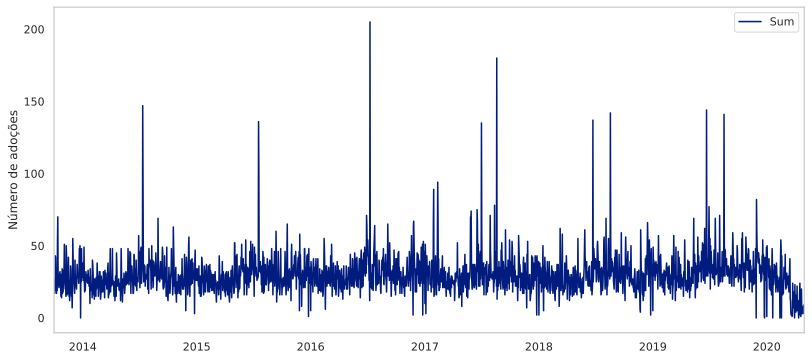

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
df_adocao.resample('D').sum().plot(ax=ax)
plt.grid(False)
plt.xlabel('')
plt.ylabel('Número de adoções')
plt.show();

##*Gráfico de adoções semanais*

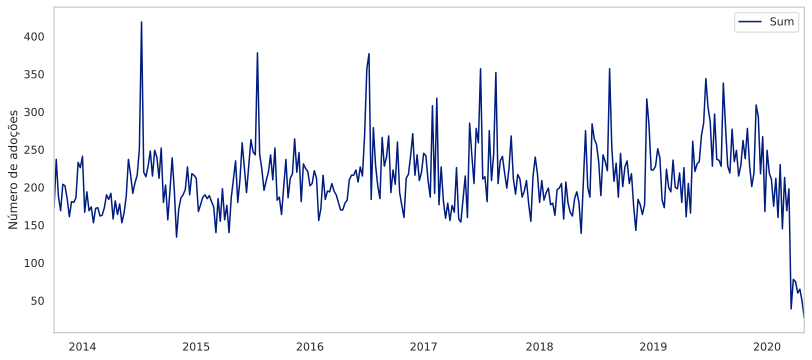

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
df_adocao.resample('W').sum().plot(ax=ax)
plt.grid(False)
plt.xlabel('')
plt.ylabel('Número de adoções')
plt.show();

##*Gráfico de adoções Mensais*

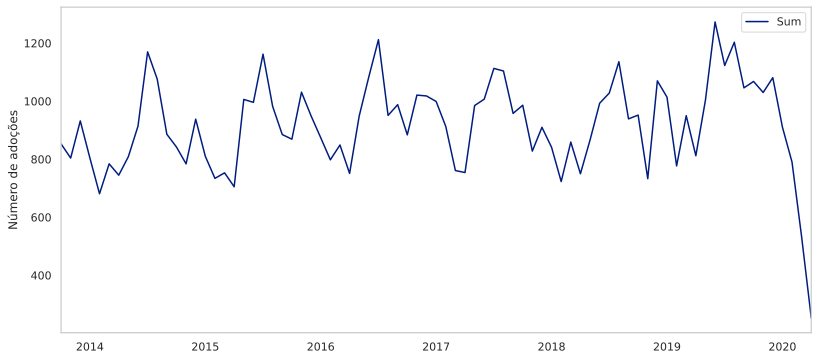

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
df_adocao.resample('M').sum().plot(ax=ax)
plt.grid(False)
plt.xlabel('')
plt.ylabel('Número de adoções')
plt.show();

#*Criando o modelo*
Para realizar comparações e adequar a melhor forma de realizar será criado um modelo diário, semanal e mensal.


##*Modelo diário*
A documentação oficial do *prophet* exige que o dataset esteja com 2 colunas, como ja foi dito, no entanto, ela também exige que a coluna com as datas seja noemada com **ds** e a coluna com as saídas dessas respectivas datas com o nome **y**.

Portanto, inicialmente, o que será feito é criar um *daframe* com as colunas nomeadas dessa forma.

In [ ]:
# modelo para dados diários
df_prophet_diario = df_adocao.resample('D').sum().reset_index().rename(
    columns = {
        'DateTime':'ds', 'Sum':'y'
    }
)

###*Estanciando e treinando o modelo*
A primeira etapa consiste em chamar a função  `Prophet` que foi importada inicialmente e a treinar com o *dataframe* criado anteriormente.

Aqui também vamos passar o número de dias que o modelo deverá predizer. No caso, será passado como parâmetro, 180 dias, mas nada impede de realizar para mais ou menos dias.

In [ ]:
# estanciando e treinando o modelo
model_diario = Prophet()
model_diario.fit(df_prophet_diario)

# período de previsão
future_diario = model_diario.make_future_dataframe(periods=30)

# forecast
forecast_diario = model_diario.predict(future_diario)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


###*Visualizando as predições feitas pelo modelo*
 

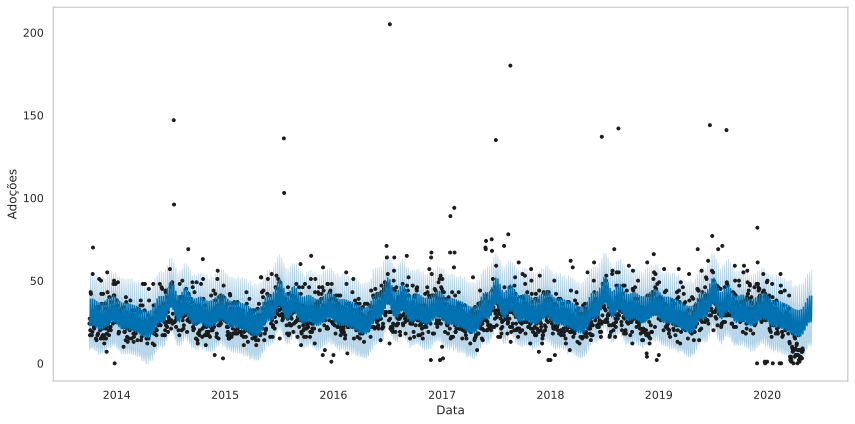

In [ ]:
# gráfico com as previsões
model_diario.plot(forecast_diario, xlabel='Data', ylabel='Adoções', figsize=(12,6));
plt.grid(False)
plt.show();

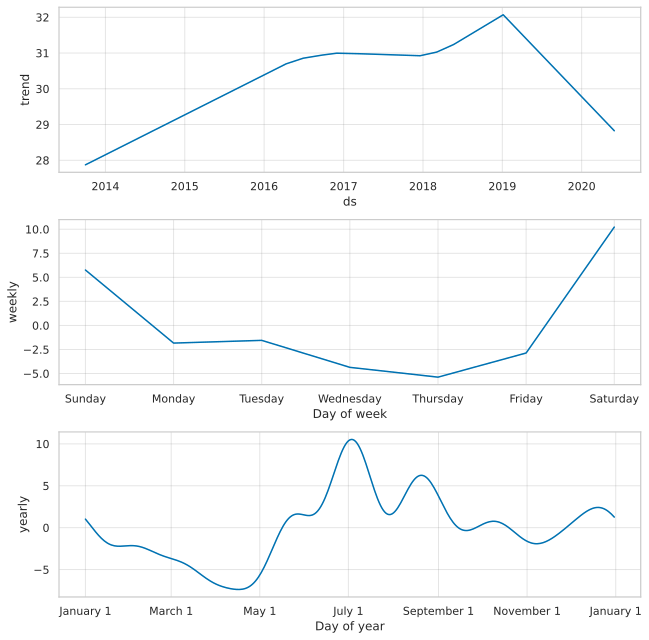

In [ ]:
# Componentes do modelo
model_diario.plot_components(forecast_diario);

Pode-se ver através desses gráficos que a tendência enm 2020 foi de queda, o que era esperado, por conta da pandemia, uma informação que pode ser visualizada também é os dias da semana onde teve mais adoções, bem como os meses onde esse número foi maior.

##*Modelo semanal*

As etapas que constituem o modelo semanal são as mesmas do modelo diário, a diferença está no momento de criar o *dataframe* que vamos usar para treinar o modelo. Enquanto no modelo diária usamos como parâmetro na função `resample()` o 'D', aqui vamos usar o parâmetro 'W' de *Week*.

In [ ]:
# modelo para dados semanais
df_prophet_week = df_adocao.resample('W').sum().reset_index().rename(
    columns={
        'DateTime':'ds', 'Sum':'y'
    }
)

In [ ]:
# criando modelo
model_week = Prophet()
model_week.fit(df_prophet_week)

# períodos de previsão
future_week = model_week.make_future_dataframe(periods=30, freq='W')

# forecast
forecast_week = model_week.predict(future_week)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


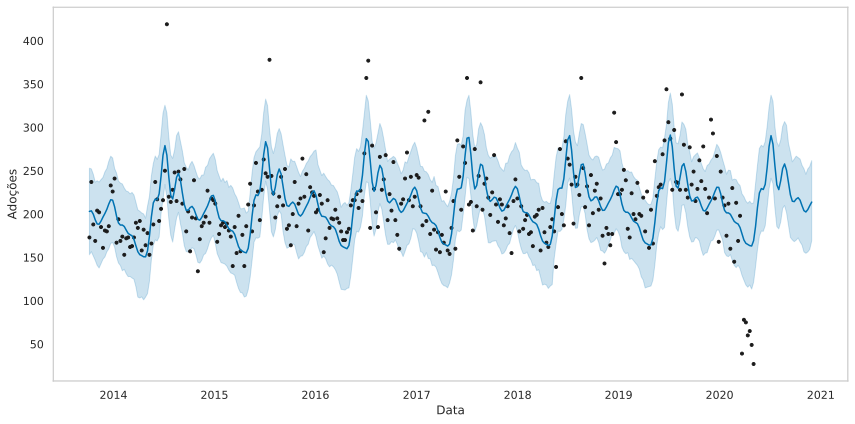

In [ ]:
# gráfico com as previsões
model_week.plot(forecast_week, xlabel='Data', ylabel='Adoções', figsize=(12,6));
plt.grid(False)
plt.show();

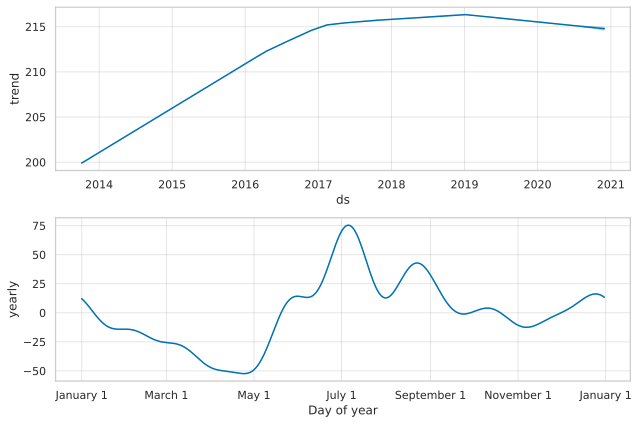

In [ ]:
# componentes do modelo
model_week.plot_components(forecast_week);

##*Modelo Mensal*

In [ ]:
# modelo para dados semanais
df_prophet_month = df_adocao.resample('M').sum().reset_index().rename(
    columns={
        'DateTime':'ds', 'Sum':'y'
    }
)

# criando modelo
model_month = Prophet()
model_month.fit(df_prophet_month)

# períodos de previsão
future_month = model_month.make_future_dataframe(periods=30, freq='M')

# forecast
forecast_month = model_month.predict(future_month)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


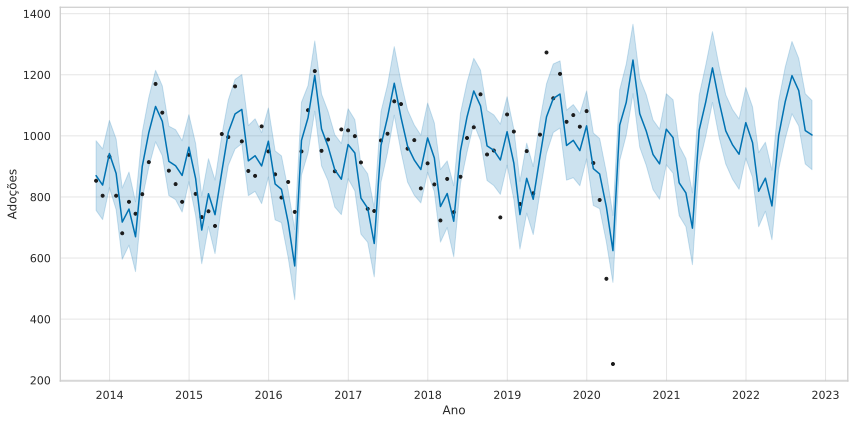

In [ ]:
model_month.plot(forecast_month, xlabel='Ano', ylabel='Adoções', figsize=(12,6));

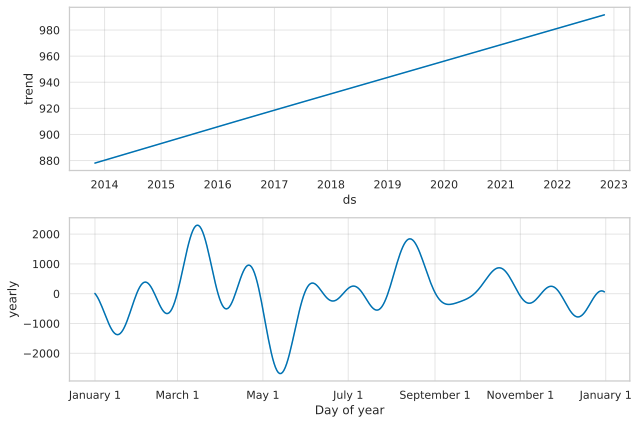

In [ ]:
model_month.plot_components(forecast_month);

#*Avaliação dos modelos*

##*Modelo Diário*

In [ ]:
df_cross_validation = cross_validation(model_diario, horizon='180 days')
df_cross_validation.head()

INFO:fbprophet:Making 19 forecasts with cutoffs between 2015-05-27 00:00:00 and 2019-11-02 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-05-28,27.098458,16.962411,38.516475,34,2015-05-27
1,2015-05-29,28.537826,17.543882,39.411102,32,2015-05-27
2,2015-05-30,42.135836,31.154159,53.165982,41,2015-05-27
3,2015-05-31,40.846281,30.020726,51.727742,32,2015-05-27
4,2015-06-01,32.065845,21.350807,43.132264,37,2015-05-27


Aqui podemos visualizar a saída original `y` e saída prevista pelo modelo `yhat`, bem como o mínimo e máximo previsto.

In [ ]:
df_performance = performance_metrics(df_cross_validation)
df_performance.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,18 days,211.714013,14.550396,8.566274,0.189563,0.836257
1,19 days,210.318607,14.502366,8.487037,0.183396,0.842105
2,20 days,210.513378,14.509079,8.525322,0.190719,0.839181
3,21 days,208.113251,14.426131,8.457875,0.192345,0.847953
4,22 days,206.040245,14.354102,8.434730,0.194364,0.845029


É possível visualizar os erros em diversas métricas, para comparar os modelos vamos usar a métrica `mdape`, quanto mais próxima de zero, melhor será o modelo.

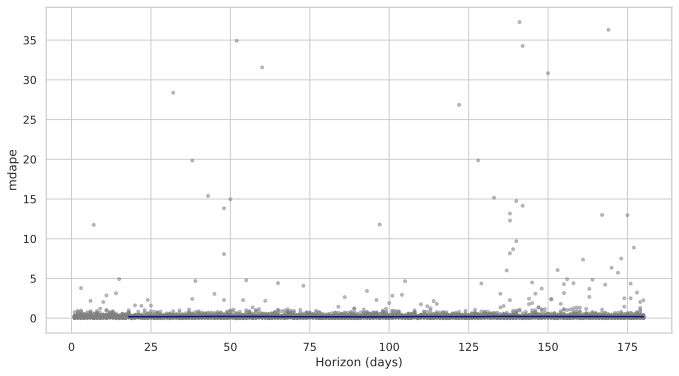

In [ ]:
# plotando o gráficos dos erros do modelo
fig = plot_cross_validation_metric(df_cross_validation, metric='mdape')

Esse tipo de gráfico é importante, uma vez que permite visualizar como a métrica de erro se comportaria conforme a data da previsão fosse mais distante.

In [ ]:
# visualizando a saídas obtidas pelo modelo
forecast_diario[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)

,ds,yhat,yhat_lower,yhat_upper
2404,2020-05-01,20.564889,5.017851,35.608082
2405,2020-05-02,33.945287,18.817301,48.734264
2406,2020-05-03,29.794241,14.602533,45.543745
2407,2020-05-04,22.532604,9.103125,37.677743
2408,2020-05-05,23.167653,8.204019,39.223001
2409,2020-05-06,20.729380,4.956125,35.966932
2410,2020-05-07,20.091602,4.894643,35.669185
2411,2020-05-08,22.993764,9.205648,38.129118
2412,2020-05-09,36.479551,21.754660,51.558715
2413,2020-05-10,32.413385,17.198901,46.971560


Onde:

* `yhat` é a saída prevista; 
* `yhat_lower` é o limite inferior previsto pelo modelo;
* `yhat_upper` é o limite superior previsto pelo modelo.

##*Modelo semanal*

In [ ]:
df_cross_validation2 = cross_validation(model_week, horizon='180 days')
df_cross_validation2.head()

INFO:fbprophet:Making 19 forecasts with cutoffs between 2015-05-30 00:00:00 and 2019-11-05 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-05-31,219.029740,185.574928,250.435864,259,2015-05-30
1,2015-06-07,214.381000,184.552085,245.860630,226,2015-05-30
2,2015-06-14,200.581877,170.173122,230.140862,193,2015-05-30
3,2015-06-21,202.220930,171.702340,234.393375,228,2015-05-30
4,2015-06-28,234.089211,202.524329,266.933778,263,2015-05-30


In [ ]:
df_performance2 = performance_metrics(df_cross_validation2)
df_performance2.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,18 days,1644.314727,40.550151,31.716404,0.145138,0.127999,0.727891
1,19 days,1522.740346,39.022306,29.475790,0.131909,0.106836,0.761905
2,20 days,1512.224715,38.887334,29.684983,0.129312,0.119308,0.755102
3,21 days,1308.483208,36.172962,27.965274,0.124827,0.108577,0.795918
4,22 days,1257.019779,35.454475,27.875100,0.128576,0.113066,0.775510


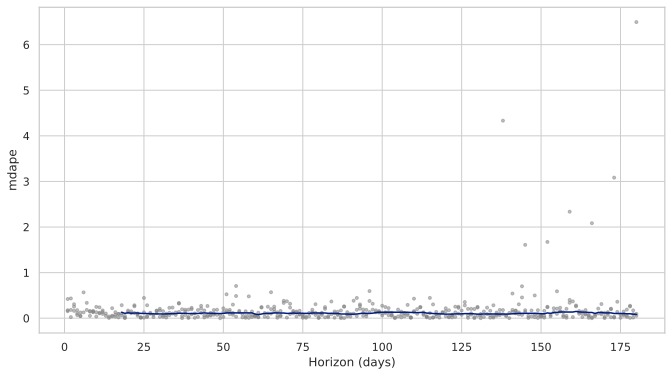

In [ ]:
fig = plot_cross_validation_metric(df_cross_validation2, metric='mdape')

In [ ]:
forecast_week[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)

,ds,yhat,yhat_lower,yhat_upper
344,2020-05-10,185.612797,139.143341,234.726271
345,2020-05-17,207.605067,159.079869,256.264927
346,2020-05-24,224.378429,174.678262,275.741081
347,2020-05-31,229.427494,180.357428,279.436520
348,2020-06-07,228.381254,180.122574,277.450952
349,2020-06-14,234.249494,186.676236,283.672652
350,2020-06-21,253.624339,207.795997,300.965270
351,2020-06-28,278.055861,229.440761,322.917522
352,2020-07-05,290.432292,241.294656,337.167812
353,2020-07-12,280.773743,235.133036,330.105248


##*Modelo Mensal*

In [ ]:
df_cross_validation3 = cross_validation(model_month, horizon='180 days')
df_cross_validation3.head()

INFO:fbprophet:Making 19 forecasts with cutoffs between 2015-05-27 00:00:00 and 2019-11-02 00:00:00


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-05-31,780.922891,780.668168,781.162482,1006,2015-05-27
1,2015-06-30,778.989857,777.968998,779.872389,996,2015-05-27
2,2015-07-31,1232.722902,1230.786367,1234.644785,1162,2015-05-27
3,2015-08-31,1170.587121,1167.460690,1173.663981,982,2015-05-27
4,2015-09-30,760.623993,756.254750,765.100052,885,2015-05-27


In [ ]:
df_performance3 = performance_metrics(df_cross_validation3)
df_performance3.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,18 days,30159.712478,173.665519,139.145113,0.149046,0.125119,0.181818
1,20 days,31075.395289,176.282147,147.978839,0.159286,0.125119,0.181818
2,22 days,26216.200735,161.914177,135.354667,0.146039,0.115952,0.181818
3,23 days,22060.049655,148.526259,121.011193,0.134896,0.115952,0.272727
4,25 days,13785.992497,117.413766,96.386209,0.108838,0.108295,0.363636


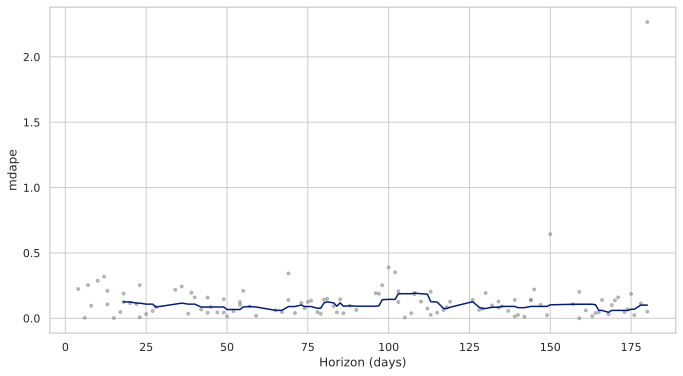

In [ ]:
fig = plot_cross_validation_metric(df_cross_validation3, metric='mdape')

In [ ]:
forecast_month[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)

,ds,yhat,yhat_lower,yhat_upper
79,2020-05-31,1035.296593,918.762492,1151.137304
80,2020-06-30,1109.367626,1002.118143,1234.575213
81,2020-07-31,1248.147071,1137.895655,1365.390139
82,2020-08-31,1072.661104,962.835647,1188.290054
83,2020-09-30,1015.468941,903.220464,1134.548101
84,2020-10-31,938.955972,824.268701,1052.130042
85,2020-11-30,908.229852,792.392188,1021.949742
86,2020-12-31,1021.743598,905.133654,1137.803244
87,2021-01-31,994.129688,877.977256,1117.944997
88,2021-02-28,846.274962,738.804473,967.809339
